## Libraries

In [11]:
import json
import pickle
import os
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.animation as animation
import matplotlib.colors as mcolors

## TEST

In [12]:
# -------------------------------
# Hàm chuyển đổi dữ liệu từ file JSON
# -------------------------------
def parse_order(order_data):
    # Lấy kích thước canvas từ order_data, nếu không có thì mặc định là [100, 100]
    canvas_size = order_data.get("canvas_size", [100, 100])
    
    # Định nghĩa mapping chuyển đổi tên sản phẩm thành id
    mapping = {"table": 1, "chair": 2, "leg": 3}
    
    # Khởi tạo danh sách rỗng để lưu các sản phẩm
    products = []
    
    # Duyệt qua từng mục trong order_data["items"]
    # item_name là tên của sản phẩm, details chứa các thông tin như kích thước và số lượng
    for item_name, details in order_data["items"].items():
        # Tạo dictionary chứa thông tin của một sản phẩm
        prod = {
            # Lấy id từ mapping, nếu không tìm thấy thì dùng giá trị mặc định là (số sản phẩm hiện có + 1)
            "id": mapping.get(item_name, len(products) + 1),
            # Đặt tên sản phẩm với chữ cái đầu được viết hoa
            "name": item_name.capitalize(),
            # Lấy chiều rộng của sản phẩm từ details["size"][0]
            "width": details["size"][0],
            # Lấy chiều dài của sản phẩm từ details["size"][1]
            "length": details["size"][1],
            # Lấy số lượng của sản phẩm từ details["quantity"]
            "quantity": details["quantity"]
        }
        # Thêm sản phẩm vừa tạo vào danh sách products
        products.append(prod)
    
    # Trả về kích thước canvas và danh sách các sản phẩm
    return canvas_size, products


In [13]:
# -------------------------------
# Hàm kiểm tra sát cạnh
# -------------------------------
def is_adjacent(pos1, size1, pos2, size2):
    r1, c1 = pos1  # Lấy tọa độ (hàng, cột) của góc trên bên trái hình chữ nhật thứ nhất
    w1, h1 = size1  # Lấy kích thước (chiều rộng, chiều cao) của hình chữ nhật thứ nhất
    r2, c2 = pos2  # Lấy tọa độ (hàng, cột) của góc trên bên trái hình chữ nhật thứ hai
    w2, h2 = size2  # Lấy kích thước (chiều rộng, chiều cao) của hình chữ nhật thứ hai
    
    # Tính toán biên của hình chữ nhật thứ nhất:
    top1, bottom1, left1, right1 = r1, r1 + h1, c1, c1 + w1  # top: hàng đầu, bottom: hàng cuối, left: cột trái, right: cột phải
    
    # Tính toán biên của hình chữ nhật thứ hai:
    top2, bottom2, left2, right2 = r2, r2 + h2, c2, c2 + w2  # Tương tự cho hình thứ hai
    
    # Kiểm tra sát cạnh theo chiều ngang:
    # Điều kiện: hai hình có giao nhau theo chiều dọc và một bên của hình 1 chạm đúng vào bên kia của hình 2
    horizontal_adj = ((bottom1 > top2) and (top1 < bottom2)) and (abs(right1 - left2) == 0 or abs(right2 - left1) == 0)
    
    # Kiểm tra sát cạnh theo chiều dọc:
    # Điều kiện: hai hình có giao nhau theo chiều ngang và một bên của hình 1 chạm đúng vào bên kia của hình 2
    vertical_adj   = ((right1 > left2) and (left1 < right2)) and (abs(bottom1 - top2) == 0 or abs(bottom2 - top1) == 0)
    
    # Trả về True nếu một trong hai điều kiện sát cạnh (chiều ngang hoặc dọc) đúng, ngược lại trả về False
    return horizontal_adj or vertical_adj


In [14]:
# -------------------------------
# Lớp môi trường cắt tấm
# -------------------------------
class MultiStockCuttingEnv:
    # Hàm khởi tạo môi trường, nhận vào kích thước canvas và dữ liệu sản phẩm
    def __init__(self, canvas_size, products_data):
        self.canvas_size = canvas_size      # Lưu kích thước canvas, ví dụ: [100, 100]
        self.products_data = products_data  # Lưu dữ liệu sản phẩm được chuyển đổi từ JSON
        self.reset()                        # Reset môi trường về trạng thái ban đầu

    # Hàm reset môi trường, khởi tạo lại stocks, products và placements
    def reset(self):
        w, h = self.canvas_size           # Giải nén kích thước canvas thành chiều rộng (w) và chiều cao (h)
        self.stocks = [self.create_new_stock(1)]  # Tạo danh sách stocks với stock đầu tiên có id = 1
        self.products = [dict(p) for p in self.products_data]  # Tạo bản sao dữ liệu sản phẩm để làm việc
        self.placements = []               # Khởi tạo danh sách placements rỗng để lưu vị trí đặt sản phẩm
        return self.get_state()            # Trả về trạng thái hiện tại của môi trường

    # Hàm tạo một stock mới với id được chỉ định
    def create_new_stock(self, stock_id):
        w, h = self.canvas_size           # Giải nén kích thước canvas
        return {
            "id": stock_id,               # Đặt id cho stock
            "width": w,                   # Gán chiều rộng của stock bằng chiều rộng canvas
            "length": h,                  # Gán chiều dài của stock bằng chiều cao canvas
            "grid": np.full((h, w), -1)   # Tạo một ma trận grid kích thước (h x w) khởi tạo với giá trị -1 (ô trống)
        }
    
    # Hàm lấy stock hiện tại (stock cuối cùng được thêm vào danh sách)
    def get_active_stock(self):
        return self.stocks[-1]
    
    # Hàm lấy trạng thái hiện tại của môi trường
    def get_state(self):
        active = self.get_active_stock()           # Lấy stock hiện tại đang hoạt động
        flat_grid = active["grid"].flatten().tolist()  # Chuyển grid của stock thành danh sách 1 chiều
        quantities = [p["quantity"] for p in self.products]  # Lấy số lượng sản phẩm còn lại của từng sản phẩm
        return tuple(flat_grid + quantities)         # Trả về trạng thái dạng tuple gồm grid và danh sách số lượng

    # Hàm kiểm tra xem các sản phẩm đã được cắt hết hay chưa (nếu quantity của tất cả đều bằng 0)
    def is_done(self):
        return not any(p["quantity"] > 0 for p in self.products)
    
    # Hàm lấy danh sách các hành động có thể thực hiện (tương ứng với các sản phẩm còn số lượng > 0)
    def get_possible_actions(self):
        return [p["id"] for p in self.products if p["quantity"] > 0]
    
    # Hàm thực hiện một bước (step) với hành động được chọn
    def step(self, action):
        # Tìm sản phẩm có id trùng với action được đưa vào
        product = next((p for p in self.products if p["id"] == action), None)
        if not product:
            return self.get_state(), -1  # Nếu không tìm thấy sản phẩm, trả về trạng thái hiện tại và penalty -1
        
        # Lấy kích thước của sản phẩm cần cắt
        w, h = product["width"], product["length"]
        active = self.get_active_stock()  # Lấy stock hiện tại đang hoạt động
        # Thử đặt sản phẩm vào stock hiện tại
        placed, pos = self.try_place_on_stock(active, action, w, h)
        if not placed:
            # Nếu không đặt được, tạo một stock mới với id tăng dần
            new_id = self.stocks[-1]["id"] + 1
            new_stock = self.create_new_stock(new_id)
            self.stocks.append(new_stock)  # Thêm stock mới vào danh sách stocks
            placed, pos = self.try_place_on_stock(new_stock, action, w, h)  # Thử đặt sản phẩm trên stock mới
            if not placed:
                return self.get_state(), -1  # Nếu vẫn không đặt được, trả về trạng thái hiện tại và penalty -1
        
        product["quantity"] -= 1  # Giảm số lượng sản phẩm đã đặt đi 1
        # Ghi nhận thông tin vị trí đặt sản phẩm (placement) vào danh sách placements
        self.placements.append({
            "stock_id": self.get_active_stock()["id"],  # Lưu id của stock hiện tại
            "piece_id": action,                         # Lưu id của sản phẩm
            "pos": pos,                                 # Lưu vị trí đặt sản phẩm (hàng, cột)
            "size": (w, h)                              # Lưu kích thước của sản phẩm (chiều rộng, chiều cao)
        })
        reward = self.compute_reward(action, pos, (w, h))  # Tính reward dựa trên vị trí và kích thước sản phẩm
        return self.get_state(), reward  # Trả về trạng thái mới và reward nhận được

    # Hàm cố gắng đặt sản phẩm có kích thước (w, h) vào stock tại vị trí phù hợp
    def try_place_on_stock(self, stock, action, w, h):
        grid = stock["grid"]                      # Lấy ma trận grid của stock
        b_w, b_h = stock["width"], stock["length"] # Lấy chiều rộng và chiều dài của stock
        # Duyệt qua các vị trí có thể đặt sản phẩm trong grid
        for r in range(b_h - h + 1):
            for c in range(b_w - w + 1):
                # Kiểm tra nếu vùng lưới từ (r, c) với kích thước (h, w) toàn bộ là -1 (chưa được sử dụng)
                if np.all(grid[r:r+h, c:c+w] == -1):
                    # Yêu cầu: sản phẩm phải đặt sát ít nhất một biên của stock
                    if not (r == 0 or c == 0 or (r+h == b_h) or (c+w == b_w)):
                        continue  # Nếu không sát biên, bỏ qua vị trí này
                    grid[r:r+h, c:c+w] = action  # Đánh dấu vùng này trong grid với giá trị là action (id của sản phẩm)
                    return True, (r, c)           # Trả về True và vị trí đặt sản phẩm (r, c)
        return False, None  # Nếu không tìm được vị trí phù hợp, trả về False và None

    # Hàm tính reward khi đặt sản phẩm với piece_id và kích thước cho trước tại vị trí pos
    def compute_reward(self, piece_id, pos, size):
        if piece_id == 1:  # Nếu sản phẩm là bàn (piece_id = 1)
            # Lấy danh sách các bàn đã được đặt
            tables = [p for p in self.placements if p["piece_id"] == 1]
            if len(tables) == 0:
                # Nếu chưa có bàn nào được đặt, kiểm tra nếu bàn được đặt ở góc của stock
                active = self.get_active_stock()
                # Xác định 4 góc của stock dựa trên kích thước sản phẩm
                corners = [
                    (0, 0),
                    (0, active["width"] - size[0]),
                    (active["length"] - size[1], 0),
                    (active["length"] - size[1], active["width"] - size[0])
                ]
                # Nếu vị trí pos nằm trong các góc, trả về reward 10, ngược lại trả về 1
                return 10 if pos in corners else 1
            elif len(tables) == 1:
                # Nếu đã có 1 bàn được đặt, kiểm tra xem bàn thứ 2 có sát với bàn đầu tiên hay không
                first = tables[0]
                sat = is_adjacent(pos, size, first["pos"], first["size"])  # Kiểm tra sự sát cạnh giữa bàn mới và bàn đầu tiên
                active = self.get_active_stock()
                # Kiểm tra nếu bàn mới đặt chạm biên của stock
                touches = (pos[0] == 0 or pos[1] == 0 or (pos[0] + size[1] == active["length"]) or (pos[1] + size[0] == active["width"]))
                return 8 if sat and touches else 1  # Nếu sát bàn và chạm biên thì reward 8, ngược lại reward 1
            else:
                # Với các trường hợp khác, sử dụng công thức reward cho các sản phẩm khác
                return self.reward_for_other(pos, size)
        else:
            # Đối với các sản phẩm không phải bàn, tính reward bằng công thức reward_for_other
            return self.reward_for_other(pos, size)
    
    # Hàm tính reward cho các sản phẩm không phải bàn (piece_id khác 1)
    def reward_for_other(self, pos, size):
        active = self.get_active_stock()  # Lấy stock hiện tại
        # Nếu sản phẩm được đặt sát biên của stock thì reward 5
        if pos[0] == 0 or pos[1] == 0 or (pos[0] + size[1] == active["length"]) or (pos[1] + size[0] == active["width"]):
            return 5
        # Kiểm tra xem sản phẩm có sát cạnh với bất kỳ sản phẩm nào đã được đặt không
        for p in self.placements:
            if p["pos"] == pos and p["size"] == size:
                continue  # Bỏ qua nếu trùng vị trí và kích thước với chính nó
            if is_adjacent(pos, size, p["pos"], p["size"]):
                return 5  # Nếu sát cạnh với sản phẩm nào đó, trả về reward 5
        return 1  # Trường hợp còn lại, trả về reward 1
    
    # Hàm tính penalty cho các ô trong stock chưa được sử dụng (giá trị -1 trong grid)
    def leftover_penalty(self):
        total_leftover = 0  # Khởi tạo tổng ô dư
        for s in self.stocks:
            total_leftover += np.sum(s["grid"] == -1)  # Cộng dồn số ô có giá trị -1 trong mỗi stock
        return -0.01 * total_leftover  # Mỗi ô dư nhận phạt -0.01
    
    # Hàm tính bonus khi tất cả sản phẩm đã được cắt hết (quantity = 0)
    def complete_bonus(self):
        return 50 if all(p["quantity"] == 0 for p in self.products) else 0
    
    # Hàm tính penalty cho việc sử dụng stock phụ (ngoại trừ stock đầu tiên)
    def stock_switch_penalty(self):
        extra_stocks = len(self.stocks) - 1  # Số stock phụ được sử dụng
        return -50 * extra_stocks           # Mỗi stock phụ nhận phạt -50


In [15]:
# -------------------------------
# Q-LEARNING AGENT
# -------------------------------
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.alpha = alpha         # Tốc độ học (learning rate)
        self.gamma = gamma         # Hệ số chiết khấu (discount factor)
        self.epsilon = epsilon     # Xác suất chọn hành động ngẫu nhiên (exploration rate)
                                   # Nếu có pretrain, khi mô phỏng có thể đặt epsilon = 0 để chỉ khai thác
        self.q_table = {}          # Bảng Q lưu trữ các giá trị Q cho từng cặp (state, action)

    # Hàm chuyển đổi trạng thái thành key dạng tuple để lưu trữ trong q_table
    def get_state_key(self, state):
        return tuple(state)        # Chuyển danh sách trạng thái thành tuple (immutable) để dùng làm key

    # Hàm chọn hành động dựa trên trạng thái hiện tại và danh sách các hành động có thể
    def choose_action(self, state, possible_actions):
        key = self.get_state_key(state)  # Lấy key của trạng thái hiện tại
        # Với xác suất epsilon, chọn hành động ngẫu nhiên (để khám phá)
        if random.random() < self.epsilon:
            return random.choice(possible_actions)
        # Lấy giá trị Q cho từng hành động khả thi; nếu không tồn tại, mặc định là 0
        q_vals = [self.q_table.get((key, a), 0) for a in possible_actions]
        # Tìm giá trị Q cao nhất trong các hành động khả thi
        max_q = max(q_vals) if q_vals else 0
        # Lọc danh sách các hành động có giá trị Q bằng giá trị cao nhất
        best_actions = [a for a, q in zip(possible_actions, q_vals) if q == max_q]
        # Nếu có nhiều hành động tối ưu, chọn ngẫu nhiên một hành động trong số chúng,
        # Nếu không, chọn ngẫu nhiên từ danh sách các hành động khả thi
        return random.choice(best_actions) if best_actions else random.choice(possible_actions)


In [16]:
# -------------------------------
# HUẤN LUYỆN Q-LEARNING (Nếu cần)
# -------------------------------
def train_q_learning(agent, env, num_episodes=500, max_steps=50):
    rewards_history = []  # Danh sách lưu lại tổng reward của mỗi episode
    for ep in range(num_episodes):  # Lặp qua từng episode huấn luyện
        state = env.reset()        # Reset môi trường về trạng thái ban đầu và lấy trạng thái ban đầu
        total_reward = 0           # Khởi tạo tổng reward của episode hiện tại
        for step in range(max_steps):  # Lặp qua từng bước trong episode (tối đa max_steps bước)
            possible_actions = env.get_possible_actions()  # Lấy danh sách các hành động có thể thực hiện tại trạng thái hiện tại
            if not possible_actions:  # Nếu không còn hành động khả thi, thoát vòng lặp bước
                break
            # Chọn hành động theo chiến lược của agent (sử dụng epsilon-greedy)
            action = agent.choose_action(state, possible_actions)
            # Thực hiện hành động trên môi trường, nhận trạng thái tiếp theo và reward tương ứng
            next_state, reward = env.step(action)
            total_reward += reward  # Cộng reward của bước hiện tại vào tổng reward của episode
            
            # Lấy key trạng thái hiện tại và trạng thái tiếp theo để truy cập bảng Q
            s_key = agent.get_state_key(state)
            ns_key = agent.get_state_key(next_state)
            # Lấy giá trị Q hiện tại cho cặp (state, action); nếu không có, mặc định là 0
            current_q = agent.q_table.get((s_key, action), 0)
            
            # Lấy danh sách hành động có thể từ trạng thái tiếp theo
            next_possible = env.get_possible_actions()
            if next_possible:
                # Tìm giá trị Q cao nhất của trạng thái tiếp theo với các hành động có thể
                max_next_q = max(agent.q_table.get((ns_key, a), 0) for a in next_possible)
            else:
                max_next_q = 0  # Nếu không có hành động nào khả thi ở trạng thái tiếp theo, đặt max_next_q = 0
            
            # Tính giá trị Q mới theo công thức Q-Learning:
            # Q(s,a) = Q(s,a) + alpha * (reward + gamma * max_next_q - Q(s,a))
            new_q = current_q + agent.alpha * (reward + agent.gamma * max_next_q - current_q)
            # Cập nhật bảng Q với giá trị mới cho cặp (state, action)
            agent.q_table[(s_key, action)] = new_q
            
            # Cập nhật trạng thái hiện tại thành trạng thái tiếp theo
            state = next_state
            if env.is_done():  # Nếu môi trường báo hiệu hoàn thành (tất cả sản phẩm đã được cắt)
                break
        # Sau mỗi episode, lưu tổng reward vào danh sách rewards_history
        rewards_history.append(total_reward)
    return rewards_history  # Trả về lịch sử reward của tất cả các episode


In [17]:
# -------------------------------
# SIMULATE EPISODE VỚI LỊCH SỬ (CHO ANIMATION)
# -------------------------------
def simulate_episode_history(agent, env, max_steps=50):
    state = env.reset()  # Reset môi trường và lấy trạng thái ban đầu
    total_reward = 0     # Khởi tạo tổng reward nhận được trong episode
    history = []         # Danh sách lưu lại lịch sử của các bước (cho animation)
    step_num = 0         # Biến đếm số bước

    # Vòng lặp thực hiện cho đến khi môi trường hoàn thành hoặc đạt số bước tối đa
    while not env.is_done() and step_num < max_steps:
        possible_actions = env.get_possible_actions()  # Lấy danh sách các hành động khả thi tại trạng thái hiện tại
        if not possible_actions:  # Nếu không còn hành động khả thi, thoát vòng lặp
            break
        # Chọn hành động dựa trên chiến lược của agent (epsilon-greedy)
        action = agent.choose_action(state, possible_actions)
        # Lưu snapshot của grid của tất cả các stock hiện có, sử dụng np.copy để tránh thay đổi dữ liệu gốc
        stocks_snapshot = [np.copy(s["grid"]) for s in env.stocks]
        # Thực hiện hành động, nhận trạng thái tiếp theo và reward
        state, reward = env.step(action)
        total_reward += reward  # Cộng reward nhận được vào tổng reward

        # Khởi tạo action_info để lưu thông tin hành động đã thực hiện (nếu có placement mới)
        action_info = None
        if env.placements:  # Nếu đã có ít nhất một placement
            last = env.placements[-1]  # Lấy thông tin của placement cuối cùng vừa được thêm vào
            action_info = {
                "product_id": last["piece_id"],      # Lưu id của sản phẩm được đặt
                "stock_idx": last["stock_id"] - 1,      # Lưu chỉ số của stock (giảm 1 vì index bắt đầu từ 0)
                "position": last["pos"],              # Lưu vị trí đặt sản phẩm (hàng, cột)
                "size": last["size"]                  # Lưu kích thước của sản phẩm (chiều rộng, chiều cao)
            }
        # Lưu lại thông tin của bước hiện tại vào history, gồm số bước, snapshot của các stock và hành động thực hiện
        history.append({
            "step": step_num,
            "stocks": stocks_snapshot,
            "action": action_info
        })
        step_num += 1  # Tăng số bước lên 1

    # Cộng thêm các phần thưởng/phạt cuối episode: phạt leftover, bonus hoàn thành và phạt chuyển stock
    total_reward += env.leftover_penalty() + env.complete_bonus() + env.stock_switch_penalty()
    return history, total_reward  # Trả về lịch sử của các bước và tổng reward của episode


In [18]:
# -------------------------------
# TÍNH WASTE RATE VÀ FITNESS
# -------------------------------
def calculate_waste_fitness(env):
    # Tính tổng diện tích của tất cả các stock:
    # Với mỗi stock, diện tích = chiều rộng * chiều dài; sau đó cộng tất cả lại
    total_stocks_area = sum(s["width"] * s["length"] for s in env.stocks)
    
    # Tính diện tích đã được sử dụng:
    # Với mỗi placement, diện tích = kích thước[0] * kích thước[1] (chiều rộng x chiều cao)
    used_area = sum(p["size"][0] * p["size"][1] for p in env.placements)
    
    # Tính diện tích chưa sử dụng (unused_area) bằng cách lấy tổng diện tích của stocks trừ đi diện tích đã sử dụng
    unused_area = total_stocks_area - used_area
    
    # Tính waste_rate:
    # Waste rate = (diện tích chưa sử dụng) / (diện tích đã sử dụng)
    # Nếu used_area > 0, tính tỉ số; nếu không, gán waste_rate = 0.0 để tránh chia cho 0
    waste_rate = (unused_area / used_area) if used_area > 0 else 0.0
    
    # Tính fitness:
    # Fitness = (diện tích đã sử dụng) / (tổng diện tích của tất cả các stock)
    # Nếu tổng diện tích > 0, tính tỉ lệ; nếu không, gán fitness = 0.0
    fitness = (used_area / total_stocks_area) if total_stocks_area > 0 else 0.0
    
    # Trả về waste_rate và fitness
    return waste_rate, fitness


In [19]:
# -------------------------------
# TRỰC QUAN HÓA KẾT QUẢ
# -------------------------------
def visualize_best_solution(env):
    num_stocks = len(env.stocks)  # Tính số lượng stock hiện có trong môi trường
    # Tạo các subplot cho từng stock, với kích thước figure phụ thuộc vào số lượng stock
    fig, axs = plt.subplots(1, num_stocks, figsize=(5*num_stocks, 6))
    # Nếu chỉ có 1 stock, chuyển axs thành danh sách để dễ duyệt trong vòng lặp
    if num_stocks == 1:
        axs = [axs]
    # Danh sách các màu được sử dụng để hiển thị các sản phẩm khác nhau
    colors = ["#FF5733", "#33FF57", "#3357FF", "#F4C724", "#A833FF", "#33FFF5", "#FF33A8"]
    # Duyệt qua từng stock và trục vẽ tương ứng
    for ax, stock in zip(axs, env.stocks):
        ax.set_title(f"Stock {stock['id']}")  # Đặt tiêu đề cho trục vẽ theo id của stock
        ax.set_xlim(0, stock["width"])         # Thiết lập giới hạn trục x theo chiều rộng của stock
        ax.set_ylim(0, stock["length"])          # Thiết lập giới hạn trục y theo chiều dài của stock
        ax.grid(True, linewidth=0.5)             # Hiển thị lưới với độ dày đường lưới là 0.5
        # Hiển thị hình nền cho stock: tạo ma trận với giá trị 1 có kích thước (length x width)
        ax.imshow(np.full((stock["length"], stock["width"]), 1), cmap='gray', vmin=0, vmax=1)
        # Vẽ các sản phẩm (placements) được đặt trên stock hiện tại
        for p in env.placements:
            if p["stock_id"] == stock["id"]:  # Chỉ vẽ các sản phẩm thuộc về stock hiện tại
                # Chọn màu dựa trên piece_id, sử dụng modulo để xoay vòng qua danh sách colors
                color = colors[(p["piece_id"] - 1) % len(colors)]
                pos = p["pos"]                # Lấy vị trí của sản phẩm (hàng, cột)
                size = p["size"]              # Lấy kích thước của sản phẩm (chiều rộng, chiều cao)
                # Tạo hình chữ nhật đại diện cho sản phẩm với các thuộc tính đã cho
                rect = patches.Rectangle((pos[1], pos[0]), size[0], size[1],
                                         linewidth=1.5, edgecolor="none",
                                         facecolor=color, alpha=0.8)
                ax.add_patch(rect)            # Thêm hình chữ nhật vào trục vẽ của stock
    plt.tight_layout()                     # Điều chỉnh layout của figure cho gọn gàng
    plt.show()                             # Hiển thị kết quả trực quan


In [20]:
# -------------------------------
# TẠO HOẠT ẢNH (GIF) CHO STOCK 1
# -------------------------------
def create_animation(history, algorithm_name):
    # Xác định số sản phẩm bằng cách tìm giá trị lớn nhất trong tất cả các grid của history (loại trừ giá trị -1),
    # sau đó cộng thêm 1 để xác định số lượng màu cần dùng.
    num_products = max([np.max(stock[stock >= 0]) if stock.size > 0 and np.max(stock) >= 0 else 0 
                        for step in history for stock in step["stocks"]]) + 1
    # Lấy colormap 'tab10' với số màu tương ứng với num_products.
    cmap = plt.cm.get_cmap('tab10', num_products)
    # Tạo danh sách các màu bằng cách lấy màu từ colormap cho từng sản phẩm.
    colors = [cmap(i) for i in range(num_products)]
    # Chèn màu cho các ô trống (giá trị -1) vào đầu danh sách; ở đây sử dụng màu xám nhạt.
    colors.insert(0, (0.9, 0.9, 0.9, 1.0))
    
    # Tạo colormap tùy chỉnh từ danh sách màu vừa tạo.
    custom_cmap = mcolors.ListedColormap(colors)
    # Xác định các ranh giới (bounds) cho colormap từ -1 đến num_products.
    bounds = list(range(-1, num_products + 1))
    # Thiết lập norm để ánh xạ các giá trị trong grid tới các màu trong custom_cmap.
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    # Xác định số lượng stock tối đa xuất hiện trong các bước của history.
    max_stocks = max(len(step["stocks"]) for step in history)
    # Xác định số cột cho layout hiển thị; không vượt quá 3 cột.
    cols = min(3, max_stocks)
    # Tính số hàng cần có để hiển thị tất cả các stock.
    rows = (max_stocks + cols - 1) // cols
    
    # Tạo figure và các trục con (axes) với kích thước phù hợp.
    fig, ax = plt.subplots(rows, cols, figsize=(12, 8))
    # Đặt tiêu đề tổng cho figure với tên thuật toán.
    fig.suptitle(f"{algorithm_name} Algorithm Visualization", fontsize=16)
    
    # Nếu chỉ có 1 stock, đảm bảo ax là mảng numpy để duyệt thống nhất.
    if rows == 1 and cols == 1:
        ax = np.array([ax])
    # Nếu có 1 hàng hoặc 1 cột, chuyển ax thành mảng phẳng.
    elif rows == 1 or cols == 1:
        ax = ax.flatten()
    
    # Tắt hiển thị cho các ô trống không chứa stock (nếu tổng số subplot nhiều hơn số stock thực tế).
    for i in range(max_stocks, rows * cols):
        if rows > 1:
            ax[i // cols, i % cols].axis('off')
        else:
            ax[i].axis('off')
    
    # Tạo đối tượng text để hiển thị thông tin bước (step) ở dưới cùng của figure.
    step_text_obj = fig.text(0.5, 0.02, "", ha='center', fontsize=12)
    
    # Định nghĩa hàm update để cập nhật nội dung cho mỗi frame của animation.
    def update(frame):
        # Lấy dữ liệu của bước hiện tại từ history.
        step_data = history[frame]
        stocks = step_data["stocks"]   # Danh sách các grid của stock tại bước này.
        action = step_data["action"]   # Thông tin hành động thực hiện ở bước này.
        step = step_data["step"]       # Số thứ tự của bước hiện tại.
        
        # Duyệt qua từng stock của bước hiện tại.
        for i, stock in enumerate(stocks):
            # Lấy trục vẽ tương ứng cho stock thứ i.
            axes = ax.flatten()[i]
            # Hiển thị grid của stock sử dụng colormap và norm đã định nghĩa.
            im = axes.imshow(stock, cmap=custom_cmap, norm=norm, origin='upper')
            # Đặt tiêu đề cho trục theo stock index.
            axes.set_title(f"Stock {i}")
            # Hiển thị lưới cho trục với đường viền màu đen và độ dày 0.5.
            axes.grid(True, which='both', color='black', linewidth=0.5)
            # Vẽ các hình chữ nhật đánh dấu các hành động (placements) đã được thực hiện đến bước hiện tại.
            for act in [h["action"] for h in history[:frame+1] if h["action"] is not None]:
                # Chỉ vẽ nếu hành động xảy ra trên stock hiện tại.
                if act["stock_idx"] == i:
                    x, y = act["position"]         # Lấy vị trí (x, y) của hành động.
                    w, h_size = act["size"]          # Lấy kích thước của sản phẩm đã đặt.
                    pid = act["product_id"]          # Lấy id của sản phẩm.
                    # Tạo hình chữ nhật để đánh dấu vị trí đặt sản phẩm (không có màu viền, chỉ để đánh dấu vị trí).
                    rect = patches.Rectangle((y, x), h_size, w, linewidth=2, edgecolor='none', facecolor='none')
                    axes.add_patch(rect)             # Thêm hình chữ nhật vào trục vẽ.
                    center_x = x + w/2               # Tính tọa độ tâm theo chiều dọc.
                    center_y = y + h_size/2          # Tính tọa độ tâm theo chiều ngang.
                    # Các dòng text hiển thị thông tin sản phẩm đã được đặt (ví dụ: product_id) đã được comment bỏ.
                    # axes.text(center_y, center_x, f'{int(pid)}',
                    #           ha='center', va='center',
                    #           color='white' if pid > 2 else 'black',
                    #           fontsize=14, fontweight='bold',
                    #           bbox=dict(boxstyle="round,pad=0.2", edgecolor="none", facecolor="none"))
        
        # Tạo chuỗi thông tin bước hiện tại, bao gồm số bước và thông tin hành động (nếu có).
        step_info = f"Step: {step}/{len(history)-1}"
        if action:
            step_info += f" | Placed product {action['product_id']} in stock {action['stock_idx']}"
        # Cập nhật text hiển thị thông tin bước.
        step_text_obj.set_text(step_info)
        return ax.flatten()  # Trả về danh sách các trục vẽ đã cập nhật
    
    # Tạo animation sử dụng FuncAnimation với các frame tương ứng với số bước trong history,
    # mỗi frame cách nhau 800 mili-giây, không sử dụng blit.
    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=800, blit=False)
    return fig, ani  # Trả về figure và đối tượng animation

# Hàm lưu animation dưới dạng file GIF
def save_animation_as_gif(ani, filename, fps=1):
    # Tạo thư mục "results" nếu nó chưa tồn tại
    os.makedirs("results", exist_ok=True)
    # Xây dựng đường dẫn file đầy đủ để lưu file GIF
    filepath = os.path.join("results", filename)
    print(f"Saving animation to {filepath}...")
    # Lưu animation với writer 'pillow' và số frame per second (fps) cho trước
    ani.save(filepath, writer='pillow', fps=fps)
    print(f"Animation saved to {filepath}")


Loaded pre-trained Q-table from E:/Q_learning (1)/q_table.pkl

Processing Order: order_001
Canvas Size: [100, 100]
  Table: 40x50 (qty: 2)
  Chair: 20x25 (qty: 4)
  Leg: 4x25 (qty: 10)
Stock Count: 1
Waste Rate: 0.4286
Fitness: 0.7
Runtime(s): 0.2649
Total Reward: 96.0


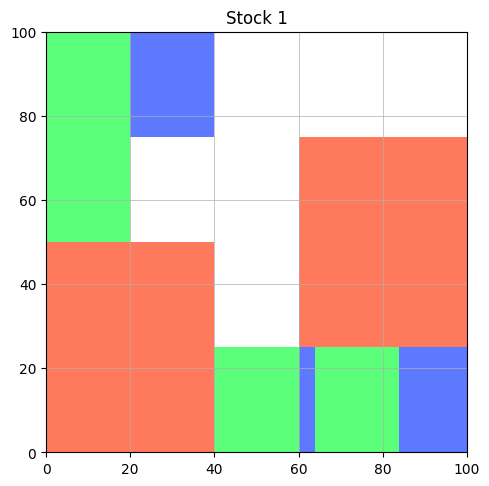

Saving animation to results\q_learning_order_001_animation.gif...

C:\Users\chuon\AppData\Local\Temp\ipykernel_10716\3233242070.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)



Animation saved to results\q_learning_order_001_animation.gif

Processing Order: order_002
Canvas Size: [100, 100]
  Table: 40x50 (qty: 1)
  Chair: 20x25 (qty: 6)
  Leg: 4x25 (qty: 20)
Stock Count: 1
Waste Rate: 0.4286
Fitness: 0.7
Runtime(s): 0.6384
Total Reward: 151.0


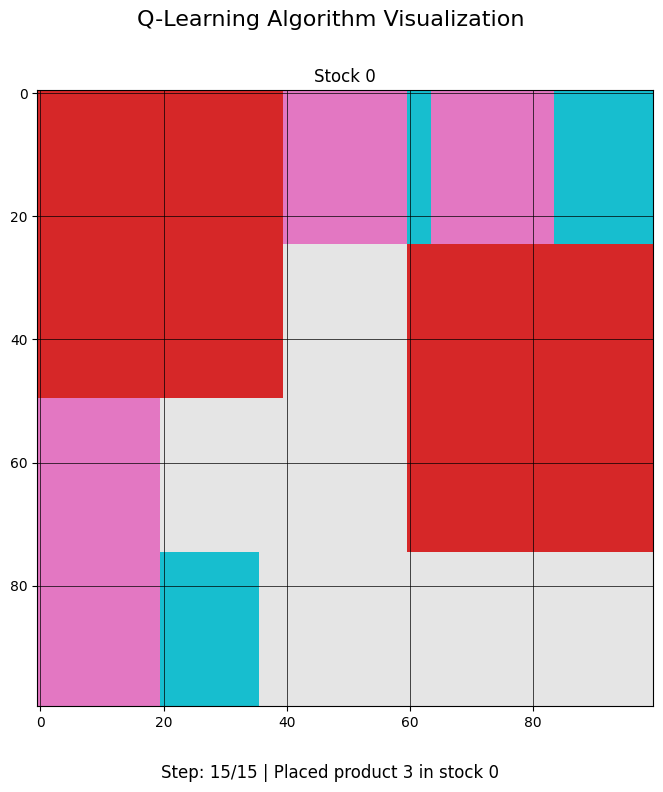

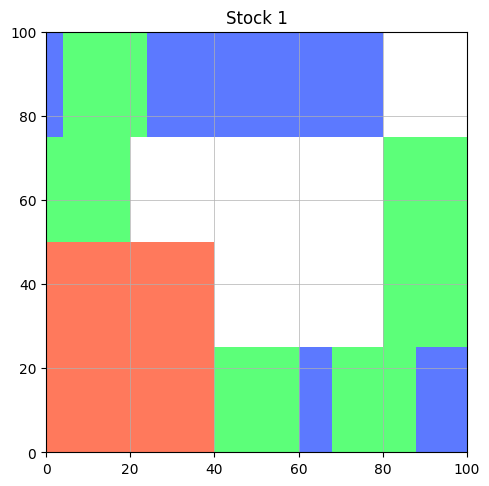

C:\Users\chuon\AppData\Local\Temp\ipykernel_10716\3233242070.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_002_animation.gif...
Animation saved to results\q_learning_order_002_animation.gif

Processing Order: order_003
Canvas Size: [100, 100]
  Table: 40x50 (qty: 3)
  Chair: 20x25 (qty: 6)
  Leg: 4x25 (qty: 25)
Stock Count: 2
Waste Rate: 0.7391
Fitness: 0.575
Runtime(s): 0.4799
Total Reward: 81.0


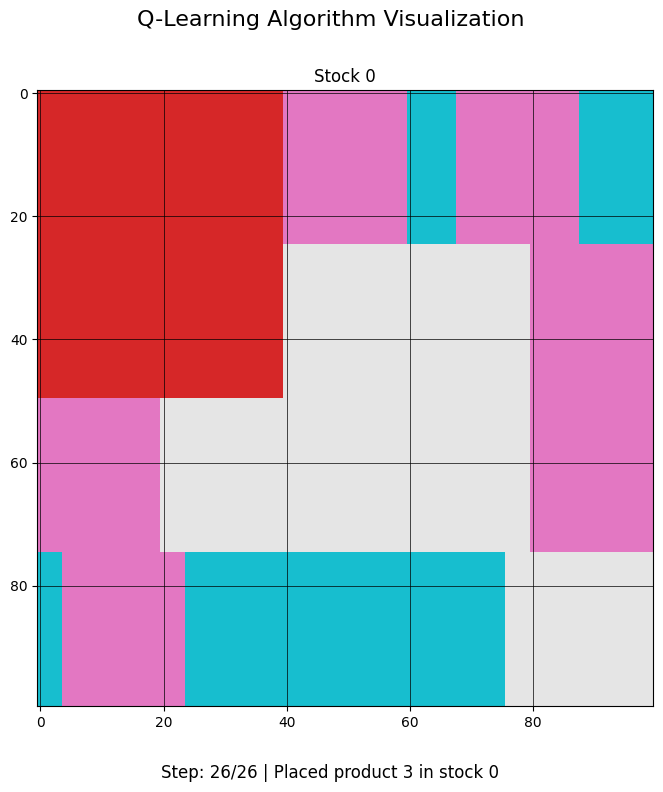

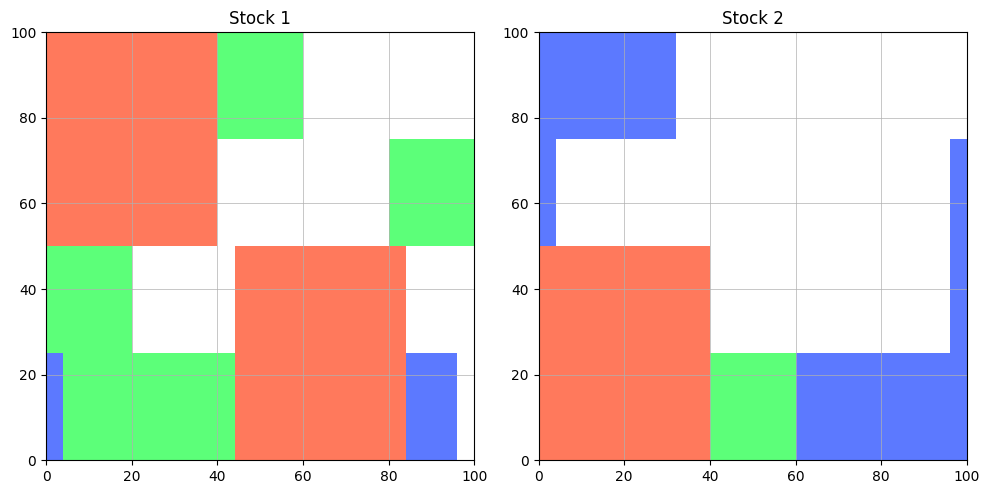

C:\Users\chuon\AppData\Local\Temp\ipykernel_10716\3233242070.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_003_animation.gif...
Animation saved to results\q_learning_order_003_animation.gif

Processing Order: order_004
Canvas Size: [100, 100]
  Table: 40x50 (qty: 4)
  Chair: 20x25 (qty: 8)
  Leg: 4x25 (qty: 30)
Stock Count: 2
Waste Rate: 0.3333
Fitness: 0.75
Runtime(s): 1.0822
Total Reward: 156.0


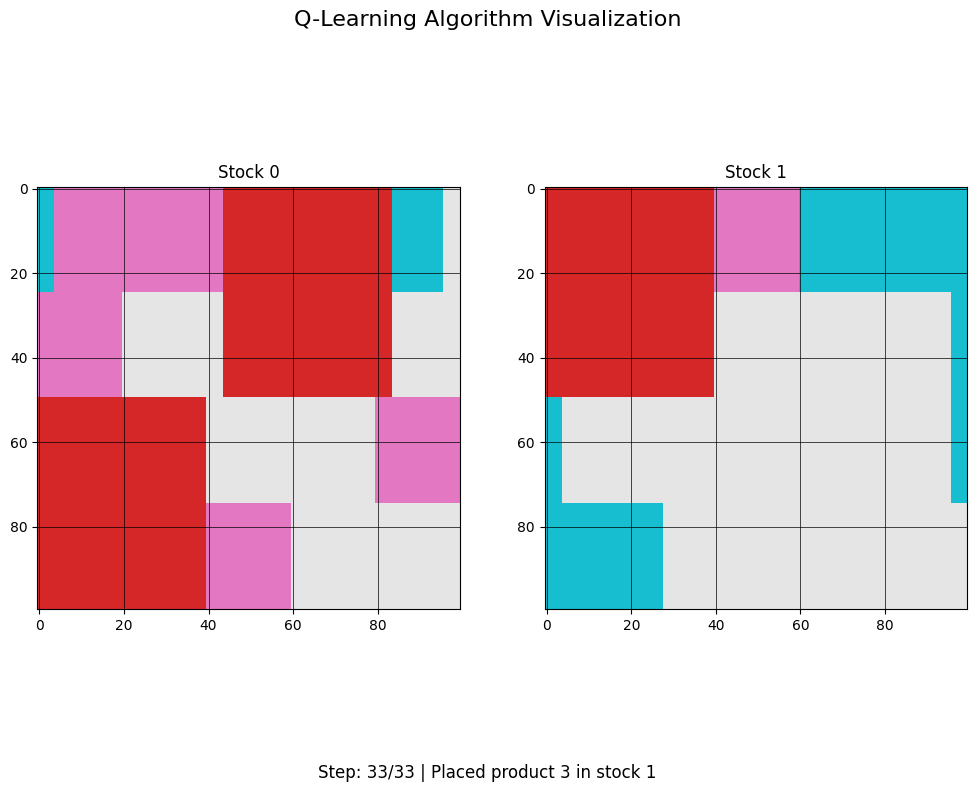

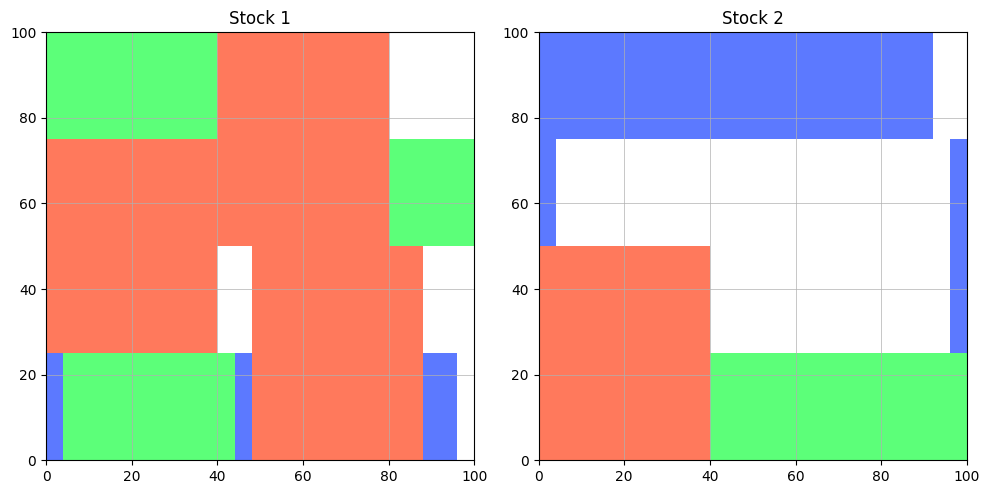

C:\Users\chuon\AppData\Local\Temp\ipykernel_10716\3233242070.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10', num_products)


Saving animation to results\q_learning_order_004_animation.gif...
Animation saved to results\q_learning_order_004_animation.gif

Q-learning BenchMark Results
----------------------------------------------------------------------
Order ID     Stock Count  Waste Rate   Fitness      Runtime(s)   Reward      
order_001    1            0.4286       0.7000       0.2649       96.0000     
order_002    1            0.4286       0.7000       0.6384       151.0000    
order_003    2            0.7391       0.5750       0.4799       81.0000     
order_004    2            0.3333       0.7500       1.0822       156.0000    


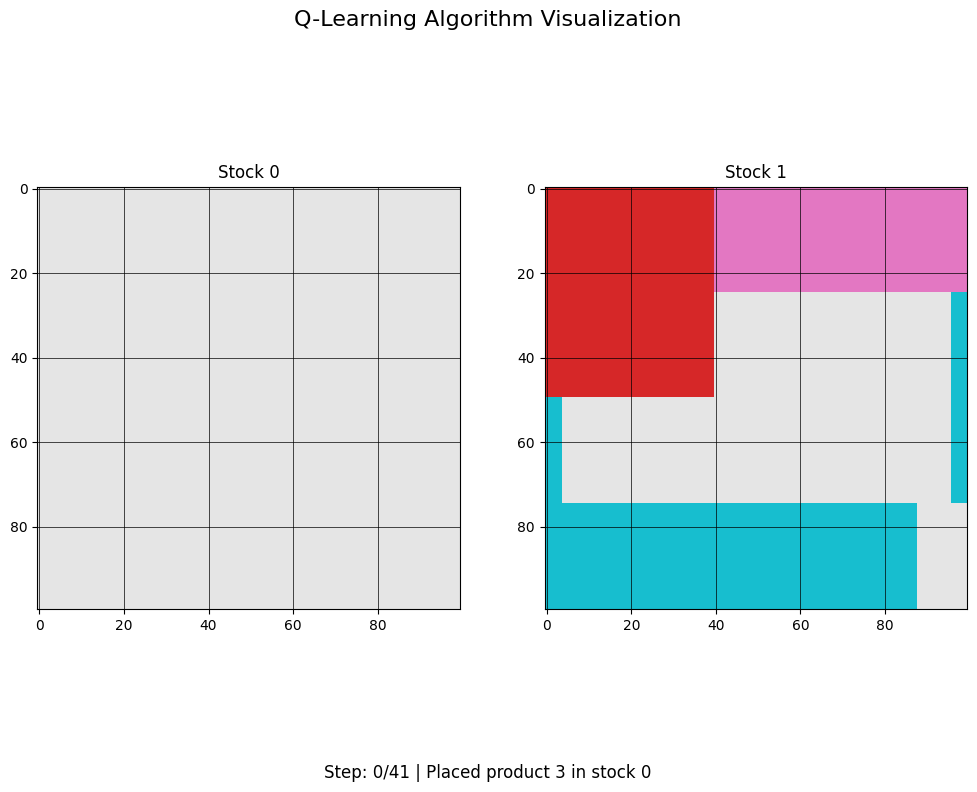

In [21]:
# -------------------------------
# MAIN
# -------------------------------
if __name__ == "__main__":
    # Đọc dữ liệu đơn hàng từ file test.json
    with open("E:/Q_learning (1)/test.json", "r") as f:
        orders = json.load(f)
    
    # Khởi tạo agent Q-learning với epsilon = 0 để luôn chọn hành động tốt nhất (chỉ khai thác, không khám phá)
    agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.0)
    # Đặt đường dẫn file chứa pre-trained Q-table
    q_table_file = "E:/Q_learning (1)/q_table.pkl"
    # Kiểm tra xem file Q-table có tồn tại không
    if os.path.exists(q_table_file):
        # Nếu file tồn tại, mở file và nạp Q-table vào agent
        with open(q_table_file, "rb") as f:
            agent.q_table = pickle.load(f)
        print("Loaded pre-trained Q-table from", q_table_file)
    else:
        # Nếu không tìm thấy file, in thông báo lỗi và thoát chương trình
        print("File", q_table_file, "not found! Vui lòng đảm bảo file pre-trained Q-table tồn tại.")
        exit(1)
    
    # Khởi tạo danh sách để lưu kết quả benchmark cho từng đơn hàng
    benchmark_results = []
    
    # Duyệt qua từng đơn hàng trong danh sách orders
    for order in orders:
        # Chuyển đổi dữ liệu đơn hàng thành kích thước canvas và danh sách sản phẩm
        canvas_size, products_data = parse_order(order)
        print("\nProcessing Order:", order["order_id"])
        print("Canvas Size:", canvas_size)
        # In thông tin chi tiết của từng sản phẩm trong đơn hàng
        for prod in products_data:
            print(f"  {prod['name']}: {prod['width']}x{prod['length']} (qty: {prod['quantity']})")
        
        # Tạo môi trường cắt tấm với kích thước canvas và dữ liệu sản phẩm của đơn hàng
        env = MultiStockCuttingEnv(canvas_size=canvas_size, products_data=products_data)
        
        # Ghi lại thời gian bắt đầu để tính thời gian chạy (runtime)
        start_time = time.time()
        # Mô phỏng một episode với lịch sử các bước và tính tổng reward nhận được
        history, total_reward = simulate_episode_history(agent, env, max_steps=50)
        # Tính thời gian chạy của episode
        runtime = time.time() - start_time
        
        # Tính tỷ lệ lãng phí (waste rate) và fitness của giải pháp dựa trên môi trường
        waste_rate, fitness = calculate_waste_fitness(env)
        # Lấy số lượng stock đã được sử dụng trong môi trường
        stock_count = len(env.stocks)
        
        # Lưu kết quả benchmark của đơn hàng hiện tại vào danh sách benchmark_results
        benchmark_results.append({
            "Order ID": order["order_id"],
            "Stock Count": stock_count,
            "Waste Rate": waste_rate,
            "Fitness": fitness,
            "Runtime(s)": runtime,
            "Total Reward": total_reward
        })
        
        # In kết quả benchmark cho đơn hàng hiện tại
        print("Stock Count:", stock_count)
        print("Waste Rate:", round(waste_rate, 4))
        print("Fitness:", round(fitness, 4))
        print("Runtime(s):", round(runtime, 4))
        print("Total Reward:", total_reward)
        
        # Trực quan hóa kết quả cuối cùng của môi trường (hiển thị các stock và sản phẩm đã đặt)
        visualize_best_solution(env)
        # Tạo animation từ lịch sử các bước của Q-learning
        fig, ani = create_animation(history, "Q-Learning")
        # Lưu animation dưới dạng file GIF, đặt fps = 1
        save_animation_as_gif(ani, f"q_learning_{order['order_id']}_animation.gif", fps=1)
    
    # In kết quả benchmark tổng hợp của tất cả các đơn hàng
    print("\nQ-learning BenchMark Results")
    print("-" * 70)
    # Tạo header cho bảng kết quả benchmark
    header = "{:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format("Order ID", "Stock Count", "Waste Rate", "Fitness", "Runtime(s)", "Reward")
    print(header)
    # Duyệt qua từng kết quả benchmark và in ra theo định dạng cột
    for r in benchmark_results:
        print("{:<12} {:<12} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
            r["Order ID"],
            r["Stock Count"],
            r["Waste Rate"],
            r["Fitness"],
            r["Runtime(s)"],
            r["Total Reward"]
        ))
